# Temporal correlations illustrating oxygen isotope fractionation mechanisms and coupling between South America d18op and ocean modes. 

Figure 5. Temporal evolution of physical processes driving δ¹⁸Oₚ in SASM core region. Correlations between 31-year running averages of area-averaged timeseries derived from boxes shown in Figure 4 as simulated by iCAM5. Correlation between ω500 and δ¹⁸Oₚ (orange line) represents the strength of upstream convective control on downstream δ¹⁸Oₚ. Correlation between δ¹⁸Oₚ and P (green line) indicates local precipitation control on oxygen isotopes (‘amount effect’). The pink line shows the correlation between the N3.4 index and δ¹⁸Oₚ. The black line is the AMO index (Trenberth and Shea, 2006). Red and blue shading highlight positive and negative phases of the IPO, respectively. All variables reflect the DJF averaged values. Confidence levels based on the adjusted degrees of freedom (df = 29) for 31-year smoothed timeseries are indicated for the 95%-significance level (dashed lines) and 99%-significance level (dotted lines). 

# preamble

In [2]:
import os.path
import numpy as np
import pandas as pd
import xarray as xr   # use xarray to open data files instead of netCDF4.  It is faster, and easier. And, it keeps my metadata!
import netCDF4 as ncd
from netCDF4 import Dataset
import scipy
import scipy.stats as stats
from scipy.stats import linregress
from scipy.stats import pearsonr

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import calendar
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter,LatitudeFormatter
import dask.array as da
from shapely.geometry.polygon import LinearRing

import proplot as pplt
import cartopy.feature as cf
import matplotlib.colors as mcols
# %matplotlib inline   # This works in jupyter notebooks, otherwise I can't use it. Also, I would need plt.show()

# ---------------------------- IGNORE PLOTTING WARNING
import warnings
from shapely.errors import ShapelyDeprecationWarning

warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

# ---------------------------- Plotting specs
plt.rc('font', family='sans-serif')
plt.rcParams.update({'font.sans-serif':'Arial'})
plt.rcParams.update({'font.size': 12})

# ---------------------------- LOADING FUNCTIONS
def detrend_dim(da, dim, deg=1):
    """
    detrend along a single dimension
    """ 
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - (fit - fit.mean())

#statistical significance for smoothed data, decreased degrees of freedom. Henry He
def t_p_test(x1, x2, lpp): 
    """
    calculate statistical significance of correlation using adjusted degrees of freedom for smoothed data
    also calculates the p value for tx1: population sample. 
    More info on calculating the pvalue with adjusted degrees of freedom here: https://docs.scipy.org/doc/scipy/tutorial/stats.html
    x2: population sample
    x3: number of smoothing units
    llp: number of years in the smoothing. 
    returns: t statistic and the p value
    """
    n = x1.shape[0]                      # ipo_index_had.shape = 130
    df = 2*n/lpp - 2                     # 2*130 / 11 - 2 = 28.889
#     nas = np.isnan(x2)
#     r = stats.pearsonr(x1[~nas], x2[~nas])[0]        # need same shape: pearsonr(ipo_index_had, var[:,0,1])[0]
    r = stats.pearsonr(x1, x2)[0]        # need same shape: pearsonr(ipo_index_had, var[:,0,1])[0]
    error = np.sqrt((1 - r**2) / df)     # sqrt needs np.
    t = r/error                          # float value
    p = stats.t.sf(np.abs(t), df)*2      # calculate p value
    return r, p

# icam5 data

In [3]:
path = "/network/rit/home/ro553136/orrison/data/CESM/iCAM5/cntl/atm/f09/"
fh_w500 = xr.open_dataset(path + "f.e13.FiPIPDC5CN.f09_f09.ctrl.cam.h0.w500_1850_2013.nc")
fh_d18o = xr.open_dataset(path + "f.e13.FiPIPDC5CN.f09_f09.ctrl.cam.h0.d18o_pwt_1850_2013.nc")
fh_p = xr.open_dataset(path + "f.e13.FiPIPDC5CN.f09_f09.ctrl.cam.h0.prect_1850_2013_mmd.nc")

lat = fh_p.lat
lon = fh_p.lon

nlat = len(lat)
nlon = len(lon)

# model data, [30:-14]: 1880 -- 1999

icam_yrs_ovr_enso = np.arange(1880,2000)

icam_om_djf_ovr_enso = fh_w500.w500[30:-14]
icam_d18odjf_ovr_enso = fh_d18o.d18o_pwt[30:-14]
icam_pdjf_ovr_enso = fh_p.prect[30:-14] 

# Calculate d18op time series, detrend box
w500_neb = np.mean(icam_om_djf_ovr_enso.sel(lat=slice(-5,10),lon=slice(295,320)),axis=(1,2))
linreg_w500 = scipy.stats.linregress(icam_yrs_ovr_enso,w500_neb)
w500_neb_a = w500_neb - (linreg_w500.slope*icam_yrs_ovr_enso + linreg_w500.intercept)

# Calculate d18op time series, detrend, box
d18_wam = np.mean(icam_d18odjf_ovr_enso.sel(lat=slice(-15,0),lon=slice(285,300)),axis=(1,2))
linreg_d18 = scipy.stats.linregress(icam_yrs_ovr_enso,d18_wam)
d18_wam_a = d18_wam - (linreg_d18.slope*icam_yrs_ovr_enso + linreg_d18.intercept)

# Calculate p time series, detrend, box
p_wam = np.mean(icam_pdjf_ovr_enso.sel(lat=slice(-15,0),lon=slice(285,300)),axis=(1,2))
linreg_p = scipy.stats.linregress(icam_yrs_ovr_enso,p_wam)
p_wam_a = p_wam - (linreg_p.slope*icam_yrs_ovr_enso + linreg_p.intercept)

In [4]:
#------------------- IPO -------------------
pth_hadsst = '/network/rit/home/ro553136/orrison/data/reconstructions/sstforc_Had_OI/'
fh_hadipo = xr.open_dataset(pth_hadsst + 'HADSSTOI_ipoinds_1880_2000.nc', decode_times= True)
ipo_index_had = fh_hadipo.tpi_index_11yr

#------------------- ENSO -------------------
pth_had = '/network/rit/home/ro553136/orrison/data/reconstructions/sstforc_Had_OI/'
fh_ens = xr.open_dataset(pth_had + "HADOISST_N34_dt_1880_2000.nc")
n34ind_had = fh_ens.n34ind_had

# - Capture only the djf season -
n34ind_djf_had = [np.nanmean(n34ind_had[11+i:14+i],axis=0) for i in range(0,1440,12)]
n34ind_djf_had_xr = xr.DataArray(n34ind_djf_had, 
    coords={'time': icam_yrs_ovr_enso}, 
    dims=["time"])

#------------------- AMO ------------------- Has ten yr low pass filter. Trenberth and Shea (2006) method.
pth_amo = '/network/rit/home/ro553136/orrison/data/observations/AMO/HadISST1/'
# f_amo = pd.read_csv(pth_amo + "amon.us.long.data", sep="\t")
f_amo = pd.read_csv(pth_amo + "amo_monthly.10yrLP.txt", sep="\t")
coln = f_amo.columns
amo_np = f_amo.loc[24:144][coln]
amo_l = []
for i in range(121):
    amo_l.append([float(x) for x in amo_np.values[i][0].split()])
# amo_l = [row.split() for row in amo_np]
df = pd.DataFrame(amo_l,columns=['year','Jan', 'Feb','Mar','Apr','May', 'Jun', 'Jul','Aug','Sep','Oct','Nov','Dec']).astype(float)
amo_per = df.set_index(df.columns[0])
amo_ann_had = amo_per.iloc[:-1].mean(axis=1)
amo_ann_had = amo_ann_had[:1999]

In [5]:
# plt.plot(icam_yrs_ovr_enso,amo_ann)
# plt.plot(icam_yrs_ovr_enso,amo_ann_11yr)
# plt.axhline(y=0)

# Running Correlations
- n34, d18op
- w500 upstream, d18op
- p local, d18op

In [6]:
w500_neb_df = pd.Series(w500_neb_a)
d18_wam_df = pd.Series(d18_wam_a)
p_wam_df = pd.Series(p_wam_a)
n34_df = pd.Series(n34ind_djf_had_xr)
ipo_df = pd.Series(ipo_index_had)

In [7]:
# mirror ends to calculate running averages: 

#------------------- w500_neb -------------------
var = w500_neb_df
nt = len(icam_yrs_ovr_enso)
filter_62yr = 62
mirror = int((filter_62yr-1)/2) # end point
copy = np.zeros((nt+2*mirror))
copy[mirror:-mirror] = var.copy()
copy[0:mirror] = var[1:mirror+1].copy()[::-1]
copy[-mirror:] = var[-1-mirror:-1].copy()[::-1]
w500_neb_mirend = pd.Series(copy)

#------------------- d18_wam -------------------
var = d18_wam_df
nt = len(icam_yrs_ovr_enso)
filter_62yr = 62
mirror = int((filter_62yr-1)/2) # end point
copy = np.zeros((nt+2*mirror))
copy[mirror:-mirror] = var.copy()
copy[0:mirror] = var[1:mirror+1].copy()[::-1]
copy[-mirror:] = var[-1-mirror:-1].copy()[::-1]
d18_wam_mirend = pd.Series(copy)

#------------------- p_wam -------------------
var = p_wam_df
nt = len(icam_yrs_ovr_enso)
filter_62yr = 62
mirror = int((filter_62yr-1)/2) # end point
copy = np.zeros((nt+2*mirror))
copy[mirror:-mirror] = var.copy()
copy[0:mirror] = var[1:mirror+1].copy()[::-1]
copy[-mirror:] = var[-1-mirror:-1].copy()[::-1]
p_wam_mirend = pd.Series(copy)

#------------------- n34 -------------------
var = n34_df
nt = len(icam_yrs_ovr_enso)
filter_62yr = 62
mirror = int((filter_62yr-1)/2) # end point
copy = np.zeros((nt+2*mirror))
copy[mirror:-mirror] = var.copy()
copy[0:mirror] = var[1:mirror+1].copy()[::-1]
copy[-mirror:] = var[-1-mirror:-1].copy()[::-1]
n34_mirend = pd.Series(copy)

#------------------- ipo -------------------
var = ipo_df
nt = len(icam_yrs_ovr_enso)
filter_62yr = 62
mirror = int((filter_62yr-1)/2) # end point
copy = np.zeros((nt+2*mirror))
copy[mirror:-mirror] = var.copy()
copy[0:mirror] = var[1:mirror+1].copy()[::-1]
copy[-mirror:] = var[-1-mirror:-1].copy()[::-1]
ipo_mirend = pd.Series(copy)

In [8]:
# Corr(d18o, w500)
d18_w500_corr = d18_wam_mirend.rolling(31).corr(w500_neb_mirend)

# Corr(d18o, P)
d18_p_corr = d18_wam_mirend.rolling(31).corr(p_wam_mirend)

# Corr(n34, d18o)
n34_d18_corr = n34_mirend.rolling(31).corr(d18_wam_mirend)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans' not found because none of the following families were found: Arial
findfont: Font family ['sans'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans' not found because none of the following families were found: Arial
findfont: Font family ['sans'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans' not found because none of the following families were found: Arial


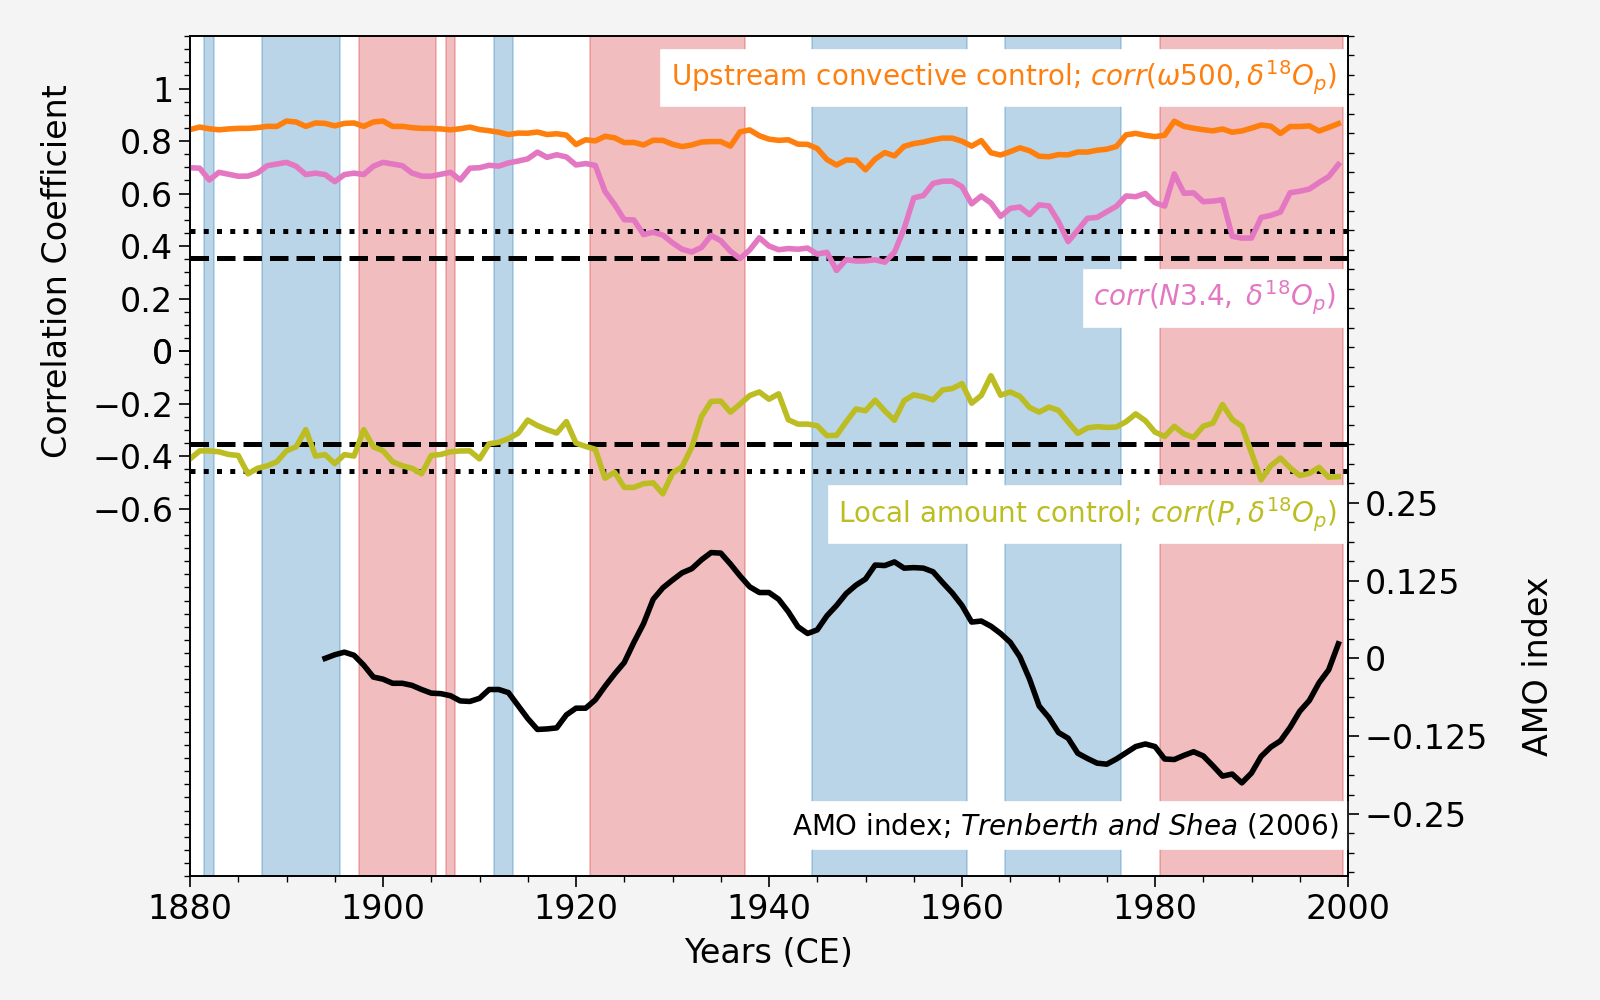

In [9]:
# 31 yr running correlation of upstream, amount effects and the enso, amo link. 
fig, ax1 = plt.subplots(figsize=(8,5))

# Pos IPO phases
plt.axvspan(1897.5, 1905.5, alpha=0.3, color='#D62728',zorder=2)  
plt.axvspan(1906.5, 1907.5, alpha=0.3, color='#D62728',zorder=2)
plt.axvspan(1921.5, 1937.5, alpha=0.3, color='#D62728',zorder=2)
plt.axvspan(1980.5, 1999.5, alpha=0.3, color='#D62728',zorder=2)

# Neg IPO phases
plt.axvspan(1881.5, 1882.5, alpha=0.3, color='#1F77B4',zorder=2)
plt.axvspan(1887.5, 1895.5, alpha=0.3, color='#1F77B4',zorder=2)
plt.axvspan(1911.5, 1913.5, alpha=0.3, color='#1F77B4',zorder=2)
plt.axvspan(1944.5, 1960.5, alpha=0.3, color='#1F77B4',zorder=2)
plt.axvspan(1964.5, 1976.5, alpha=0.3, color='#1F77B4',zorder=2)

ax2 = ax1.twinx()
    
    # Plot correlation lines, AMO index
    # w500, d18o - upstream convection
ax1.plot(icam_yrs_ovr_enso,d18_w500_corr[30:-30],linewidth=2., color='#FF7F0E', zorder=10)
    # P, d18o - amount effect
ax1.plot(icam_yrs_ovr_enso,d18_p_corr[30:-30],linewidth=2., color='#BCBD22', zorder=10)
    # n34, d18o - pacific link
ax1.plot(icam_yrs_ovr_enso,n34_d18_corr[30:-30],linewidth=2., color='#E377C2', zorder=10)
    # AMO index
ax2.plot(icam_yrs_ovr_enso[14:], amo_ann_had, linewidth=2., color='#000000',zorder=10)

    # axis formatting
ax1.set_xlabel('Years (CE)')
ax1.set_ylim(-2,1.2)
ax1.set_yticks([-0.6,-0.4,-0.2, 0,0.2,0.4,0.,0.6,0.8,1.0])
# ax1.set_yticks([-0.625,-0.8,-0.375,-0.25,-0.125, 0,0.125,0.25,0.375,0.8,0.625,0.75,0.875,1.0])
# ax1.tick_params(axis='both', which='minor', labelsize=9)
ax1.set_ylabel('Correlation Coefficient')
ax1.yaxis.set_label_coords(-0.1,0.72)
ax2.set_ylim(-0.35,1.)
ax2.set_yticks([-0.25,-0.125, 0,0.125,0.25])
# ax2.tick_params(axis='y', which='major', labelsize=9)
ax2.set_ylabel('AMO index')
ax2.yaxis.set_label_coords(1.15,0.25)
ax1.grid(False)
ax2.grid(False)


# # Label lines
plt.text(0.415, 0.94, r'Upstream convective control; $\it{corr(\omega500, \delta^{18}O_p)}$',color='#FF7F0E',backgroundcolor='w',size=10,zorder=2,transform=ax1.transAxes)
plt.text(0.78, 0.678, r'$\it{corr(N 3.4,\; \delta^{18}O_p)}$',color='#E377C2',backgroundcolor='w',size=10,zorder=2,transform=ax1.transAxes)
# plt.text(0.56, 0.628, r'Local amount control; $\it{corr(P, \delta^{18}O_p)}$',color='#BCBD22',backgroundcolor='w',size=10,zorder=2,transform=ax1.transAxes)
plt.text(0.56, 0.42, r'Local amount control; $\it{corr(P, \delta^{18}O_p)}$',color='#BCBD22',backgroundcolor='w',size=10,zorder=2,transform=ax1.transAxes)
plt.text(0.52, 0.05, r'AMO index; $\it{Trenberth\ and\ Shea\ (2006)}$',color='black',backgroundcolor='w',size=10,zorder=2,transform=ax1.transAxes)
# set significance lines
ax1.axhline(y=0.4556,linewidth=1.8, color='black',linestyle='dotted')   # p > 0.001
ax1.axhline(y=0.355,linewidth=1.8, color='black',linestyle='dashed')   # p > 0.05
ax1.axhline(y=-0.4556,linewidth=1.8, color='black',linestyle='dotted')   # p > 0.001
ax1.axhline(y=-0.355,linewidth=1.8, color='black',linestyle='dashed')   # p > 0.05

plt.xlim(1880,2000)
plt.tight_layout()
# plt.savefig('/network/rit/home/ro553136/orrison/Plots/Pac_SAm/Fig5_run_corr_amo.jpg',format='JPEG',dpi=300)
plt.show()